In [1]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.3'
spark_version = 'spark-3.5.4'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [2]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [3]:

# 1. Read the cleaned_data.csv from the url location into a PySpark DataFrame.
from pyspark import SparkFiles
url = "https://raw.githubusercontent.com/hillz246/digital_market_csv/refs/heads/main/cleaned_data.csv"


In [4]:
spark.sparkContext.addFile(url)
digital_market_df = spark.read.csv(SparkFiles.get("cleaned_data.csv"), sep=",", header=True)
digital_market_df.show()


+----------+---+------+------+---------------+-------------+-------+----------------+--------------+-------------+-------------+----------+------------+----------+-----------+-----------------+-------------+----------+
|CustomerID|Age|Gender|Income|CampaignChannel| CampaignType|AdSpend|ClickThroughRate|ConversionRate|WebsiteVisits|PagesPerVisit|TimeOnSite|SocialShares|EmailOpens|EmailClicks|PreviousPurchases|LoyaltyPoints|Conversion|
+----------+---+------+------+---------------+-------------+-------+----------------+--------------+-------------+-------------+----------+------------+----------+-----------+-----------------+-------------+----------+
|      8000| 56|Female|136912|   Social Media|    Awareness|6497.87|          0.0439|         0.088|            0|        2.399|    7.3968|          19|         6|          9|                4|          688|         1|
|      8001| 69|  Male| 41760|          Email|    Retention|3898.67|          0.1557|        0.1827|           42|       2.9

In [5]:
# Get the data types of the columns
digital_market_df.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- CampaignChannel: string (nullable = true)
 |-- CampaignType: string (nullable = true)
 |-- AdSpend: string (nullable = true)
 |-- ClickThroughRate: string (nullable = true)
 |-- ConversionRate: string (nullable = true)
 |-- WebsiteVisits: string (nullable = true)
 |-- PagesPerVisit: string (nullable = true)
 |-- TimeOnSite: string (nullable = true)
 |-- SocialShares: string (nullable = true)
 |-- EmailOpens: string (nullable = true)
 |-- EmailClicks: string (nullable = true)
 |-- PreviousPurchases: string (nullable = true)
 |-- LoyaltyPoints: string (nullable = true)
 |-- Conversion: string (nullable = true)



In [6]:
from pyspark.sql.functions import col
# List of columns that should be converted to Integer or Float
int_columns = ["CustomerID", "Age", "LoyaltyPoints", "PreviousPurchases", "SocialShares", "EmailOpens", "EmailClicks", "WebsiteVisits", "Income", "Conversion"]
float_columns = ["AdSpend", "ClickThroughRate", "ConversionRate", "PagesPerVisit", "TimeOnSite"]
# Convert integer columns
for col_name in int_columns:
    digital_market_df = digital_market_df.withColumn(col_name, col(col_name).cast("int"))
# Convert float columns
for col_name in float_columns:
    digital_market_df = digital_market_df.withColumn(col_name, col(col_name).cast("float"))
# Verify the changes
digital_market_df.printSchema()
digital_market_df.show(5)

root
 |-- CustomerID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- CampaignChannel: string (nullable = true)
 |-- CampaignType: string (nullable = true)
 |-- AdSpend: float (nullable = true)
 |-- ClickThroughRate: float (nullable = true)
 |-- ConversionRate: float (nullable = true)
 |-- WebsiteVisits: integer (nullable = true)
 |-- PagesPerVisit: float (nullable = true)
 |-- TimeOnSite: float (nullable = true)
 |-- SocialShares: integer (nullable = true)
 |-- EmailOpens: integer (nullable = true)
 |-- EmailClicks: integer (nullable = true)
 |-- PreviousPurchases: integer (nullable = true)
 |-- LoyaltyPoints: integer (nullable = true)
 |-- Conversion: integer (nullable = true)

+----------+---+------+------+---------------+------------+-------+----------------+--------------+-------------+-------------+----------+------------+----------+-----------+-----------------+-------------+---------

In [7]:
# 2. Create a temporary view of the DataFrame.
digital_market_df.createOrReplaceTempView('CampaignMarket')

Campaign Success Metrics

1. **conversion Rate**:  Calculate the conversion rate as the percentage of users who converted (e.g., made a purchase) divided by the total number of users

In [8]:
# Run SQL query to calculate Conversion Rate
conversion_rate_sql = spark.sql("""
    SELECT
        (SUM(Conversion) / COUNT(*)) * 100 AS ConversionRate
    FROM CampaignMarket
""")

# Show the result
conversion_rate_sql.show(truncate=False)

+-----------------+
|ConversionRate   |
+-----------------+
|87.64999999999999|
+-----------------+



2. Click-Through Rate (CTR): Calculate the CTR as the percentage of clicks relative to impressions (views).

In [9]:
# Run SQL query to calculate Click-Through Rate (CTR)
ctr_sql = spark.sql("""
    SELECT
        (SUM(ClickThroughRate) / COUNT(*)) * 100 AS CTR
    FROM CampaignMarket
""")

# Show the result
ctr_sql.show(truncate=False)

+------------------+
|CTR               |
+------------------+
|15.482914998359046|
+------------------+



3. Average Transaction Value: Calculate the average transaction value (e.g., average purchase amount) based on available data.

In [10]:
# Run SQL query to calculate Average Transaction Value (Alternative CLV estimate)
start_time = time.time()

clv_sql = spark.sql("""
    SELECT
        AVG(total_ad_spend) AS AvgTransactionValue
    FROM (
        SELECT
            CustomerID,
            SUM(AdSpend) AS total_ad_spend
        FROM CampaignMarket
        GROUP BY CustomerID
    ) AS customer_ad_spend
""")

# Show the result
clv_sql.show(truncate=False)

print("--- %s seconds ---" % (time.time() - start_time))

+-------------------+
|AvgTransactionValue|
+-------------------+
|5000.944855964661  |
+-------------------+

--- 4.179638624191284 seconds ---


with original CampaignMarket table without cache - query time 2.25 seconds

In [11]:
# Cache the the temporary table home_sales.
spark.sql("CACHE TABLE CampaignMarket")

DataFrame[]

In [12]:
# Check if the table is cached.
spark.catalog.isCached('CampaignMarket')

True

In [13]:
# Using the cached data, run the last query above,
 # Determine the runtime and compare it to the uncached runtime.

start_time = time.time()
clv_sql = spark.sql("""
    SELECT
        AVG(total_ad_spend) AS AvgTransactionValue
    FROM (
        SELECT
            CustomerID,
            SUM(AdSpend) AS total_ad_spend
        FROM CampaignMarket
        GROUP BY CustomerID
    ) AS customer_ad_spend
""")

# Show the result
clv_sql.show(truncate=False)

print("--- %s seconds ---" % (time.time() - start_time))




+-------------------+
|AvgTransactionValue|
+-------------------+
|5000.944855964661  |
+-------------------+

--- 1.7390148639678955 seconds ---


CampaignMarket table with cache - query time 1.22 seconds

In [14]:
# Partition by the "date_built" field on the formatted parquet home sales data
digital_market_df.write.mode("overwrite").partitionBy("CampaignChannel").parquet("CampaignMarket_partitioned")

In [15]:
# Read the parquet formatted data.
CampaignMarket_partitioned_df = spark.read.parquet("CampaignMarket_partitioned")

CampaignMarket_partitioned_df.show()

+----------+---+------+------+-------------+-------+----------------+--------------+-------------+-------------+----------+------------+----------+-----------+-----------------+-------------+----------+---------------+
|CustomerID|Age|Gender|Income| CampaignType|AdSpend|ClickThroughRate|ConversionRate|WebsiteVisits|PagesPerVisit|TimeOnSite|SocialShares|EmailOpens|EmailClicks|PreviousPurchases|LoyaltyPoints|Conversion|CampaignChannel|
+----------+---+------+------+-------------+-------+----------------+--------------+-------------+-------------+----------+------------+----------+-----------+-----------------+-------------+----------+---------------+
|      8006| 38|Female| 25615|    Awareness| 7302.9|           0.041|         0.061|           42|        1.754|   10.6987|          54|        14|          3|                6|          930|         1|       Referral|
|      8023| 19|Female| 72243|   Conversion|5144.34|          0.0775|        0.0615|           33|       6.5909|    2.0531| 

In [16]:
# create a temporary table for the parquet data
CampaignMarket_partitioned_df.createOrReplaceTempView('CampaignMarket_temp')

In [17]:
# Using parquet Dataframe, run the last query above,
# determine the runtime and compare it to the cashed runtime.

start_time = time.time()
clv_sql = spark.sql("""
    SELECT
        AVG(total_ad_spend) AS AvgTransactionValue
    FROM (
        SELECT
            CustomerID,
            SUM(AdSpend) AS total_ad_spend
        FROM CampaignMarket_temp
        GROUP BY CustomerID
    ) AS customer_ad_spend
""")

# Show the result
clv_sql.show(truncate=False)

print("--- %s seconds ---" % (time.time() - start_time))

+-------------------+
|AvgTransactionValue|
+-------------------+
|5000.944855964661  |
+-------------------+

--- 1.430795669555664 seconds ---


the runtime campare it to the cashed CampaignMarket with campaignMarket_temp table  - query time 1.06 seconds

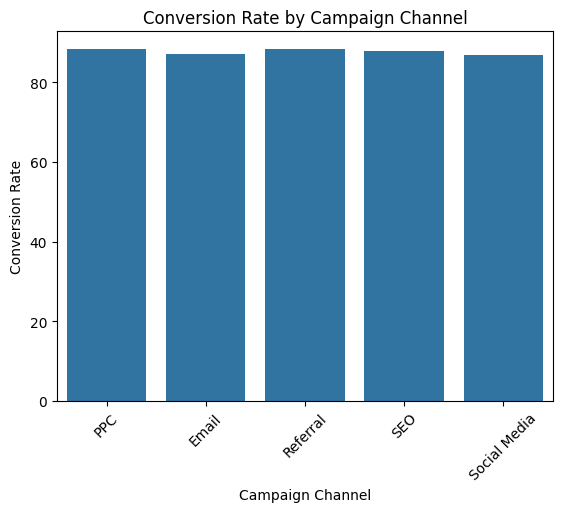

In [18]:
# Run SQL query to calculate Conversion Rate by CampaignChannel (extra)
conversion_rate_sql = spark.sql("""
    SELECT
        CampaignChannel,
        (SUM(Conversion) / COUNT(*)) * 100 AS ConversionRate
    FROM CampaignMarket_temp
    GROUP BY CampaignChannel
""")

# Convert the result to a Pandas DataFrame for plotting
conversion_rate_pd = conversion_rate_sql.toPandas()

# Now, use seaborn and matplotlib to plot the barplot
import seaborn as sns
import matplotlib.pyplot as plt

# Create the bar plot
sns.barplot(x='CampaignChannel', y='ConversionRate', data=conversion_rate_pd)

# Customize the plot
plt.xlabel("Campaign Channel")
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate by Campaign Channel")
plt.xticks(rotation=45)

# Show the plot
plt.show()

5.  Income Segmentation: To explore how income levels impact customer behavior, you can create a box plot

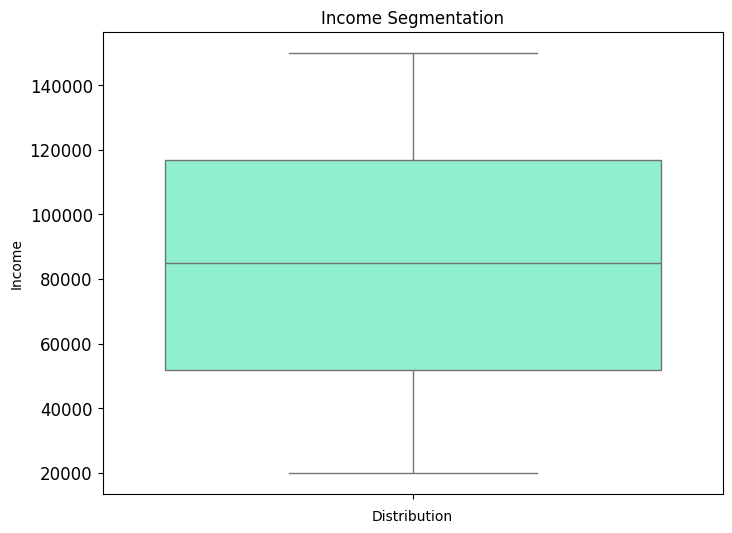

In [19]:
# Run SQL query to select the 'Income' data (question: how to display values of income in plot)
income_sql = spark.sql("""
    SELECT Income
    FROM CampaignMarket_temp
""")

# Convert the result to a Pandas DataFrame for plotting
income_pd = income_sql.toPandas()

# Now, use seaborn and matplotlib to create the box plot
import seaborn as sns
import matplotlib.pyplot as plt

# Create the figure with a custom size
plt.figure(figsize=(8, 6))

# Create the box plot for 'Income' distribution
sns.boxplot(y=income_pd['Income'].values, color='aquamarine')

# Customize the plot
plt.xlabel("Distribution")
plt.ylabel("Income")
plt.title("Income Segmentation")


# Display numbers (tick marks) on both axes

plt.xticks(rotation=90)  # Rotate x-axis labels if needed (to avoid overlap)
plt.yticks(fontsize=12)  # Adjust fontsize for y-axis ticks if desired

# Show the plot
plt.show()

Customer Retention Metrics:
1. Returning Visitors: To monitor returning visitors, you can track the number of unique users who visit your website more than once

In [20]:
# Run a Spark SQL query to count the number of returning visitors (WebsiteVisits > 1)
returning_visitors_sql = spark.sql("""
    SELECT COUNT(*) AS returning_visitors
    FROM CampaignMarket_temp
    WHERE WebsiteVisits > 1
""")

# Show the result
returning_visitors_sql.show()

+------------------+
|returning_visitors|
+------------------+
|              7700|
+------------------+



Email Engagement

2. Email Engagement: Measure email opens, clicks, and conversions based on available data (e.g., ‘EmailOpens’, ‘EmailClicks’, ‘Conversion’).

In [21]:
# Run a Spark SQL query to calculate average of 'EmailOpens' and 'EmailClicks' from CampaignMarket
start_time = time.time()
avg_email_sql = spark.sql("""
    SELECT
        AVG(EmailOpens) AS avg_email_opens,
        AVG(EmailClicks) AS avg_email_clicks
    FROM CampaignMarket_temp
""")

# Show the result
avg_email_sql.show()
print("--- %s seconds ---" % (time.time() - start_time))

+---------------+----------------+
|avg_email_opens|avg_email_clicks|
+---------------+----------------+
|       9.476875|        4.467375|
+---------------+----------------+

--- 0.47895002365112305 seconds ---


3. Previous Purchases: Understand repeat purchase behavior by analyzing how many times customers made purchases.

In [22]:
# Run a Spark SQL query to count the number of repeat purchases (PreviousPurchases > 1)
repeat_purchase_sql = spark.sql("""
    SELECT COUNT(*) AS repeat_purchase_count
    FROM CampaignMarket_temp
    WHERE PreviousPurchases > 1
""")

# Show the result
repeat_purchase_sql.show()

+---------------------+
|repeat_purchase_count|
+---------------------+
|                 6368|
+---------------------+



In [23]:
# Uncache the home_sales temporary table.
spark.sql('uncache table CampaignMarket')

DataFrame[]

In [24]:
# Check if the home_sales is no longer cached
spark.catalog.isCached('CampaignMarket')

False

In [25]:
# Uncache the home_sales temporary table.
spark.sql('uncache table CampaignMarket_temp')

DataFrame[]

In [26]:
# Check if the home_sales is no longer cached
spark.catalog.isCached('CampaignMarket_temp')

False

# Machine learning

In [50]:

# 1. Read the cleaned_data.csv from the url location into a PySpark DataFrame.
from pyspark import SparkFiles
url = "https://raw.githubusercontent.com/hillz246/digital_market_csv/refs/heads/main/cleaned_data.csv"


In [51]:
spark.sparkContext.addFile(url)
digital_market_df = spark.read.csv(SparkFiles.get("cleaned_data.csv"), sep=",", header=True)
digital_market_df.show()


+----------+---+------+------+---------------+-------------+-------+----------------+--------------+-------------+-------------+----------+------------+----------+-----------+-----------------+-------------+----------+
|CustomerID|Age|Gender|Income|CampaignChannel| CampaignType|AdSpend|ClickThroughRate|ConversionRate|WebsiteVisits|PagesPerVisit|TimeOnSite|SocialShares|EmailOpens|EmailClicks|PreviousPurchases|LoyaltyPoints|Conversion|
+----------+---+------+------+---------------+-------------+-------+----------------+--------------+-------------+-------------+----------+------------+----------+-----------+-----------------+-------------+----------+
|      8000| 56|Female|136912|   Social Media|    Awareness|6497.87|          0.0439|         0.088|            0|        2.399|    7.3968|          19|         6|          9|                4|          688|         1|
|      8001| 69|  Male| 41760|          Email|    Retention|3898.67|          0.1557|        0.1827|           42|       2.9

In [52]:
# Get the data types of the columns
digital_market_df.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- CampaignChannel: string (nullable = true)
 |-- CampaignType: string (nullable = true)
 |-- AdSpend: string (nullable = true)
 |-- ClickThroughRate: string (nullable = true)
 |-- ConversionRate: string (nullable = true)
 |-- WebsiteVisits: string (nullable = true)
 |-- PagesPerVisit: string (nullable = true)
 |-- TimeOnSite: string (nullable = true)
 |-- SocialShares: string (nullable = true)
 |-- EmailOpens: string (nullable = true)
 |-- EmailClicks: string (nullable = true)
 |-- PreviousPurchases: string (nullable = true)
 |-- LoyaltyPoints: string (nullable = true)
 |-- Conversion: string (nullable = true)



In [53]:
from pyspark.sql.functions import col
# List of columns that should be converted to Integer or Float
int_columns = ["CustomerID", "Age", "LoyaltyPoints", "PreviousPurchases", "SocialShares", "EmailOpens", "EmailClicks", "WebsiteVisits", "Income", "Conversion"]
float_columns = ["AdSpend", "ClickThroughRate", "ConversionRate", "PagesPerVisit", "TimeOnSite"]
# Convert integer columns
for col_name in int_columns:
    digital_market_df = digital_market_df.withColumn(col_name, col(col_name).cast("int"))
# Convert float columns
for col_name in float_columns:
    digital_market_df = digital_market_df.withColumn(col_name, col(col_name).cast("float"))
# Verify the changes
digital_market_df.printSchema()
digital_market_df.show(5)

root
 |-- CustomerID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- CampaignChannel: string (nullable = true)
 |-- CampaignType: string (nullable = true)
 |-- AdSpend: float (nullable = true)
 |-- ClickThroughRate: float (nullable = true)
 |-- ConversionRate: float (nullable = true)
 |-- WebsiteVisits: integer (nullable = true)
 |-- PagesPerVisit: float (nullable = true)
 |-- TimeOnSite: float (nullable = true)
 |-- SocialShares: integer (nullable = true)
 |-- EmailOpens: integer (nullable = true)
 |-- EmailClicks: integer (nullable = true)
 |-- PreviousPurchases: integer (nullable = true)
 |-- LoyaltyPoints: integer (nullable = true)
 |-- Conversion: integer (nullable = true)

+----------+---+------+------+---------------+------------+-------+----------------+--------------+-------------+-------------+----------+------------+----------+-----------+-----------------+-------------+---------

**Split the Data into Training and Testing Sets**
Step 1: Read the cleaned_data data from the URL (github) into a Pandas DataFrame.

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import numpy as np

from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report

In [72]:
digital_market_df.head()

Row(CustomerID=8000, Age=56, Gender='Female', Income=136912, CampaignChannel='Social Media', CampaignType='Awareness', AdSpend=6497.8701171875, ClickThroughRate=0.04390000179409981, ConversionRate=0.08799999952316284, WebsiteVisits=0, PagesPerVisit=2.3989999294281006, TimeOnSite=7.3968000411987305, SocialShares=19, EmailOpens=6, EmailClicks=9, PreviousPurchases=4, LoyaltyPoints=688, Conversion=1)

In [73]:
digital_market_df.dtypes

[('CustomerID', 'int'),
 ('Age', 'int'),
 ('Gender', 'string'),
 ('Income', 'int'),
 ('CampaignChannel', 'string'),
 ('CampaignType', 'string'),
 ('AdSpend', 'float'),
 ('ClickThroughRate', 'float'),
 ('ConversionRate', 'float'),
 ('WebsiteVisits', 'int'),
 ('PagesPerVisit', 'float'),
 ('TimeOnSite', 'float'),
 ('SocialShares', 'int'),
 ('EmailOpens', 'int'),
 ('EmailClicks', 'int'),
 ('PreviousPurchases', 'int'),
 ('LoyaltyPoints', 'int'),
 ('Conversion', 'int')]

In [74]:
# Convert PySpark DataFrame to Pandas DataFrame
digital_market_pd = digital_market_df.toPandas() # Display the first few rows digital_market_pd.head()
digital_market_pd

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870117,0.0439,0.0880,0,2.3990,7.3968,19,6,9,4,688,1
1,8001,69,Male,41760,Email,Retention,3898.669922,0.1557,0.1827,42,2.9171,5.3525,5,2,7,2,3459,1
2,8002,46,Female,88456,PPC,Awareness,1546.430054,0.2775,0.0764,2,8.2236,13.7949,0,11,2,8,2337,1
3,8003,32,Female,44085,PPC,Conversion,539.530029,0.1376,0.0880,47,4.5409,14.6884,89,2,2,0,2463,1
4,8004,60,Female,83964,PPC,Conversion,1678.040039,0.2529,0.1099,0,2.0468,13.9934,6,6,6,8,4345,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,15995,21,Male,24849,Email,Awareness,8518.309570,0.2438,0.1168,23,9.6936,14.2278,70,13,6,7,286,0
7996,15996,43,Female,44718,SEO,Retention,1424.609985,0.2367,0.1901,49,9.4990,3.5011,52,13,1,5,1502,0
7997,15997,28,Female,125471,Referral,Consideration,4609.529785,0.0565,0.1338,35,2.8532,14.6183,38,16,0,3,738,1
7998,15998,19,Female,107862,PPC,Consideration,9476.110352,0.0240,0.1384,49,1.0030,3.8766,86,1,5,7,2709,1


In [75]:
digital_market_pd.shape

(8000, 18)

In [76]:
# Set CustomerID as the index
digital_market_pd.set_index("CustomerID", inplace=True)
# Display the first few rows
digital_market_pd.head()

,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
CustomerID,,,,,,,,,,,,,,,,,
8000,56,Female,136912,Social Media,Awareness,6497.870117,0.0439,0.0880,0,2.3990,7.3968,19,6,9,4,688,1
8001,69,Male,41760,Email,Retention,3898.669922,0.1557,0.1827,42,2.9171,5.3525,5,2,7,2,3459,1
8002,46,Female,88456,PPC,Awareness,1546.430054,0.2775,0.0764,2,8.2236,13.7949,0,11,2,8,2337,1
8003,32,Female,44085,PPC,Conversion,539.530029,0.1376,0.0880,47,4.5409,14.6884,89,2,2,0,2463,1
8004,60,Female,83964,PPC,Conversion,1678.040039,0.2529,0.1099,0,2.0468,13.9934,6,6,6,8,4345,1


In [77]:
digital_market_pd.dtypes

,0
Age,int32
Gender,object
Income,int32
CampaignChannel,object
CampaignType,object
AdSpend,float32
ClickThroughRate,float32
ConversionRate,float32
WebsiteVisits,int32
PagesPerVisit,float32


In [78]:
digital_market_pd.columns

Index(['Age', 'Gender', 'Income', 'CampaignChannel', 'CampaignType', 'AdSpend',
       'ClickThroughRate', 'ConversionRate', 'WebsiteVisits', 'PagesPerVisit',
       'TimeOnSite', 'SocialShares', 'EmailOpens', 'EmailClicks',
       'PreviousPurchases', 'LoyaltyPoints', 'Conversion'],
      dtype='object')

In [79]:
#import
import pandas as pd

#convert categorial data to numeric with 'pd.get_dummies')
numeric_market_df = pd.get_dummies(digital_market_pd, dtype="int64")
numeric_market_df

,Age,Income,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,...,Gender_Male,CampaignChannel_Email,CampaignChannel_PPC,CampaignChannel_Referral,CampaignChannel_SEO,CampaignChannel_Social Media,CampaignType_Awareness,CampaignType_Consideration,CampaignType_Conversion,CampaignType_Retention
CustomerID,,,,,,,,,,,,,,,,,,,,,
8000,56,136912,6497.870117,0.0439,0.0880,0,2.3990,7.3968,19,6,...,0,0,0,0,0,1,1,0,0,0
8001,69,41760,3898.669922,0.1557,0.1827,42,2.9171,5.3525,5,2,...,1,1,0,0,0,0,0,0,0,1
8002,46,88456,1546.430054,0.2775,0.0764,2,8.2236,13.7949,0,11,...,0,0,1,0,0,0,1,0,0,0
8003,32,44085,539.530029,0.1376,0.0880,47,4.5409,14.6884,89,2,...,0,0,1,0,0,0,0,0,1,0
8004,60,83964,1678.040039,0.2529,0.1099,0,2.0468,13.9934,6,6,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,21,24849,8518.309570,0.2438,0.1168,23,9.6936,14.2278,70,13,...,1,1,0,0,0,0,1,0,0,0
15996,43,44718,1424.609985,0.2367,0.1901,49,9.4990,3.5011,52,13,...,0,0,0,0,1,0,0,0,0,1
15997,28,125471,4609.529785,0.0565,0.1338,35,2.8532,14.6183,38,16,...,0,0,0,1,0,0,0,1,0,0


Step 2: Create the labels set (y) from the “Conversion” column, and then create the features (X) DataFrame from the remaining columns.

In [80]:
print(numeric_market_df["Conversion"].value_counts())
# Split our preprocessed data into our features and target arrays

y = numeric_market_df["Conversion"].values
X = numeric_market_df.drop(["Conversion"], axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

Conversion
1    7012
0     988
Name: count, dtype: int64


Step 3: Split the data into training and testing datasets

In [81]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [82]:
X

array([[5.60000000e+01, 1.36912000e+05, 6.49787012e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.90000000e+01, 4.17600000e+04, 3.89866992e+03, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [4.60000000e+01, 8.84560000e+04, 1.54643005e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.80000000e+01, 1.25471000e+05, 4.60952979e+03, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.90000000e+01, 1.07862000e+05, 9.47611035e+03, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.10000000e+01, 9.30020000e+04, 7.74362988e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [83]:
y

array([1, 1, 1, ..., 1, 1, 0], dtype=int32)

Step 3: Split the data into training and testing datasets by using train_test_split.

In [84]:
# Import the train_test_learn module
from sklearn.model_selection import train_test_split

# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## **Classification:**

Create a Logistic Regression Model with the Original Data

Step 1: Fit a logistic regression model by using the training data (X_train and y_train).

In [85]:
# Import the LogisticRegression module from SKLearn
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
model = LogisticRegression(random_state=1)

# Fit the model using training data
model.fit(X_train,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1)

Step 2: Save the predictions on the testing data labels by using the testing feature data (X_test) and the fitted model.

In [86]:
# Make a prediction using the testing data
y_pred = model.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

Step 3: Evaluate the model’s performance by doing the following:

*   Generate a confusion matrix.
*   Print the classification report.

In [87]:
# Generate a confusion matrix for the model
confusion_matrix(y_test,y_pred)

array([[   0,  234],
       [   0, 1766]])

In [88]:
# Print the classification report for the model
class_report = classification_report(y_test,y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.88      1.00      0.94      1766

    accuracy                           0.88      2000
   macro avg       0.44      0.50      0.47      2000
weighted avg       0.78      0.88      0.83      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Analysis: The accuracy score from model is 88%.
The recall for 1 with 0.88, 0.60 for (0).

The precision for 1 is 0.88 indicating some conversions are incorrectly classified as potential customers.

# **Neural Network**

**Attempt 1:**

First hidden_nodes_layer1 =  8 -> relu

Second hidden_nodes_layer2 = 5 -> sigmoid

Output Layer -> sigmoid



In [96]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  8
hidden_nodes_layer2 = 5


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 8)                   │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │              45 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251 (1004.00 B)

 Trainable params: 251 (1004.00 B)

 Non-trainable params: 0 (0.00 B)

In [97]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [98]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7136 - loss: 0.6134
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8688 - loss: 0.4135
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8807 - loss: 0.3834
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8665 - loss: 0.4037
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8728 - loss: 0.3842
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8756 - loss: 0.3774
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8768 - loss: 0.3737
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8718 - loss: 0.3800
Epoch 9/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8698 - loss: 0.3839
Epoch 10/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8741 - loss: 0.3763
Epoch 11/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8769 - loss: 0.3663
Epoch 12/100
188/188 ━━━━━━━━━━━━━━━━━━━━

In [99]:
# Evaluate the model using the test data - FIRST ATTEMPT
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

63/63 - 0s - 5ms/step - accuracy: 0.8830 - loss: 0.3854
Loss: 0.38543176651000977, Accuracy: 0.8830000162124634


In [100]:
# Export our model to HDF5 file
#  To Save a Tensorflow Model-- this is the code to do it:
# Export our model to HDF5 file
nn.save("digital_marketing_model.h5")

<Axes: >

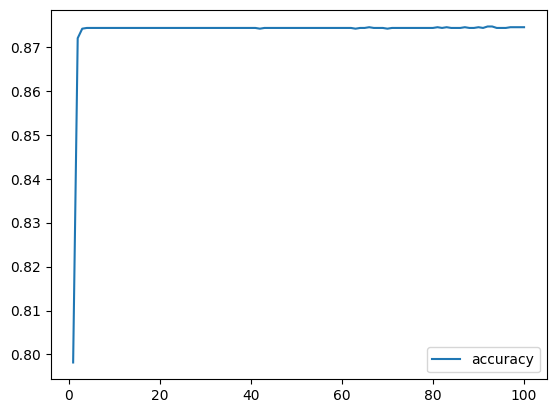

In [101]:
# plotting the accuracy
history_df = pd.DataFrame(fit_model.history, index = range(1, len(fit_model.history['loss'])+1))
history_df.plot(y = 'accuracy')


Attempt 2:

First hidden_nodes_layer1 = 30 -> relu

Second hidden_nodes_layer2 = 20 -> sigmoid

Second hidden_nodes_layer2 = 17 -> sigmoid

Second hidden_nodes_layer2 = 5 -> sigmoid

Output Layer -> sigmoid


In [102]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  30
hidden_nodes_layer2 = 20
hidden_nodes_layer3 = 17
hidden_nodes_layer4 = 5

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="tanh"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="tanh"))

# Forth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 30)                  │             750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 20)                  │             620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 17)                  │             357 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │              90 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,823 (7.12 KB)

 Trainable params: 1,823 (7.12 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [104]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8659 - loss: 0.4140
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8832 - loss: 0.3587
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8708 - loss: 0.3793
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8784 - loss: 0.3585
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8737 - loss: 0.3640
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8697 - loss: 0.3734
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8788 - loss: 0.3473
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8745 - loss: 0.3535
Epoch 9/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8666 - loss: 0.3666
Epoch 10/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8694 - loss: 0.3588
Epoch 11/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8737 - loss: 0.3498
Epoch 12/100
188/188 ━━━━━━━━━━━━━━━━━━━━

In [105]:
# Evaluate the model using the test data - Second ATTEMPT
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

63/63 - 0s - 5ms/step - accuracy: 0.7930 - loss: 0.8906
Loss: 0.890623152256012, Accuracy: 0.7929999828338623


In [106]:
# Export our model to HDF5 file
nn.save('Conversion2.h5')

accuracy: 0.8540 - loss: 0.8611

We randomly split the data into training and test datasets using scikit-learn's train_test_split method.​

Normalized both datasets using scikit-learn's StandardScaler class.​

Using the Keras module, created a basic neural network with two neurons in the hidden layer.​

Trained the neural network model with 100 epochs.​

Evaluated the performance of our model by printing our test loss metric and determined the predictive accuracy of the model on the test dataset.​

Additionally created a new neural network with a different number of neurons.​

Trained the new neural network model on the same training data and tested the performance on the same testing dataset.

TensorFlow is a neural network and machine learning library for Python that has become an industry standard for developing robust neural network models.

# Random Forest

Fitting the Random Forest Model

Once the data is scaled, create a random forest instance and train it with the training data (X_train_scaled and y_train), define n_estimators=500 and random_state=78.

In [107]:
# Initial imports
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report



In [108]:
# Create the random forest classifier instance
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [109]:
# Fit the model and use .ravel()on the "y_train" data.
rf_model = rf_model.fit(X_train_scaled, y_train.ravel())

Making Predictions Using the Random Forest Model

Validate the trained model by predicting loan defaults using the testing data (X_test_scaled).

In [110]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

Model Evaluation

Evaluate model's results, by using sklearn to calculate the confusion matrix, the accuracy score and to generate the classification report.

In [111]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [112]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,0,234
Actual 1,0,1766


Accuracy Score : 0.883
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.88      1.00      0.94      1766

    accuracy                           0.88      2000
   macro avg       0.44      0.50      0.47      2000
weighted avg       0.78      0.88      0.83      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [113]:
# Calculating the balance accuracy score
balanced_accuracy = balanced_accuracy_score(y_test, predictions)
balanced_accuracy

0.5

Feature Importance

In this section, you are asked to fetch the features' importance from the random forest model and display the top 10 most important features.

In [114]:
# Get the feature importance array
# List the top 10 most important features
importances = rf_model.feature_importances_
names = numeric_market_df.drop(["Conversion"], axis=1).columns

importance_df = pd.DataFrame({'importance': importances}, index=names).sort_values('importance', ascending=False)
display(importance_df.head(10))

,importance
PagesPerVisit,0.083378
Income,0.082289
LoyaltyPoints,0.081054
ConversionRate,0.080048
AdSpend,0.079694
TimeOnSite,0.079147
ClickThroughRate,0.077772
SocialShares,0.069015
Age,0.065181
WebsiteVisits,0.064603


<ipython-input-115-5cc53d048b76>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df.head(10).importance, y=importance_df.head(10).index, palette="viridis")


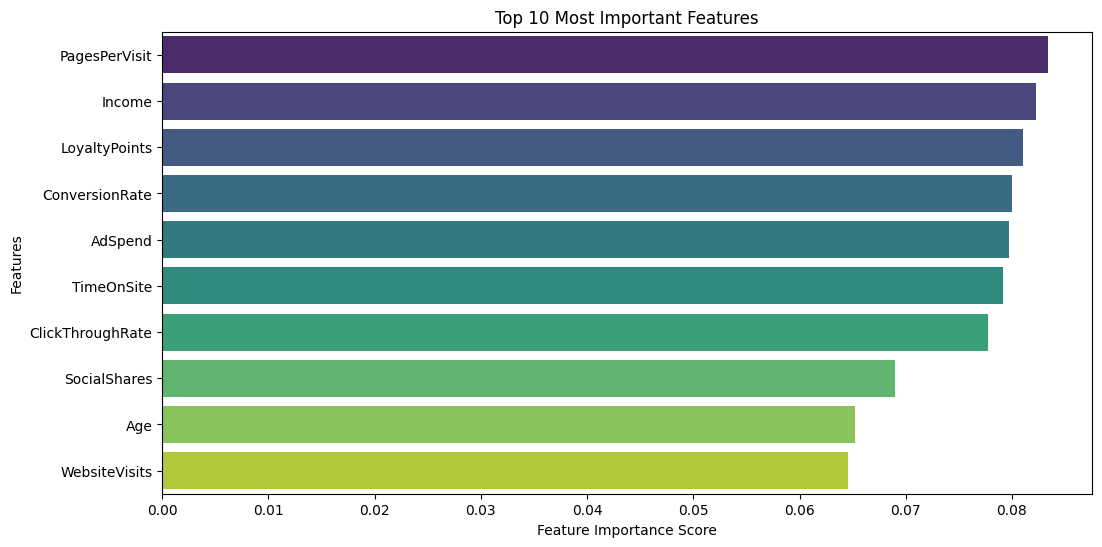

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot the top 10 features
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_df.head(10).importance, y=importance_df.head(10).index, palette="viridis")
# Add labels and title
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 10 Most Important Features")
plt.show()